In [83]:
import matplotlib.pyplot as plt

import numpy as np


from l5kit.data import ChunkedDataset, LocalDataManager
from l5kit.dataset import EgoDataset, AgentDataset
from l5kit.geometry.transform import *

from l5kit.rasterization import build_rasterizer
from l5kit.configs import load_config_data
from l5kit.geometry import transform_points, rotation33_as_yaw
from tqdm import tqdm
from collections import Counter
from l5kit.rasterization.rasterizer_builder import _load_metadata
from prettytable import PrettyTable

import os

# from l5kit.visualization.visualizer.zarr_utils import zarr_to_visualizer_scene
# from l5kit.visualization.visualizer.visualizer import visualize
from bokeh.io import output_notebook, show
from l5kit.data import MapAPI

from scenario import get_lanes, lane_check, current_lane


In [85]:
# set env variable for data
os.environ["L5KIT_DATA_FOLDER"] = "C:\\Users\\zheng\\Desktop\\UMich\\Independent Study\\prediction-dataset"
# get config
cfg = load_config_data("C:\\Users\\zheng\\Desktop\\UMich\\Independent Study\\Codes\\python codes\\visualisation_config.yaml")
print(cfg)

dm = LocalDataManager()
dataset_path = dm.require(cfg["val_data_loader"]["key"])
zarr_dataset = ChunkedDataset(dataset_path)
zarr_dataset.open()
print(zarr_dataset)

rast = build_rasterizer(cfg, dm)
ego_dataset = EgoDataset(cfg, zarr_dataset, rast)
# agent_dataset = AgentDataset(cfg, zarr_dataset, rast)
# Obatin the information from semantic map

semantic_map_filepath = dm.require(cfg["raster_params"]["semantic_map_key"])
dataset_meta = _load_metadata(cfg["raster_params"]["dataset_meta_key"], dm)
world_to_ecef = np.array(dataset_meta["world_to_ecef"], dtype=np.float64)
Map_Api = MapAPI(semantic_map_filepath, world_to_ecef)

# Load all lane information into one dictionary
all_lanes = get_lanes(Map_Api)
Lane = {Map_Api.id_as_str(lane.id):lane.element.lane for lane in all_lanes}

{'format_version': 4, 'model_params': {'model_architecture': 'resnet50', 'history_num_frames': 0, 'future_num_frames': 50, 'step_time': 0.1}, 'raster_params': {'raster_size': [320, 320], 'pixel_size': [0.5, 0.5], 'ego_center': [0.6, 0.5], 'map_type': 'py_semantic', 'satellite_map_key': 'aerial_map/aerial_map.png', 'semantic_map_key': 'semantic_map/semantic_map.pb', 'dataset_meta_key': 'meta.json', 'filter_agents_threshold': 0.5, 'disable_traffic_light_faces': False, 'set_origin_to_bottom': True}, 'val_data_loader': {'key': 'scenes/train.zarr', 'batch_size': 12, 'shuffle': False, 'num_workers': 16}}
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+------

In [45]:
# now find the scene which are absolutely making a turn
scene_list = []
tunring_scenes = []

for scene in tqdm(range(len(zarr_dataset.scenes))):
    
    start_frame = frames[zarr_dataset.scenes[scene]["frame_index_interval"][0]]
    finish_frame = frames[zarr_dataset.scenes[scene]["frame_index_interval"][1]-1]
    
    start_yaw = rotation33_as_yaw(start_frame["ego_rotation"])
    finish_yaw = rotation33_as_yaw(finish_frame["ego_rotation"])
    
    
    if abs(start_yaw-finish_yaw) > 1:
        scene_list.append(scene)
        tunring_scenes += list(range(zarr_dataset.scenes[scene]["frame_index_interval"][0],zarr_dataset.scenes[scene]["frame_index_interval"][1]))
    

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16265/16265 [00:26<00:00, 607.90it/s]


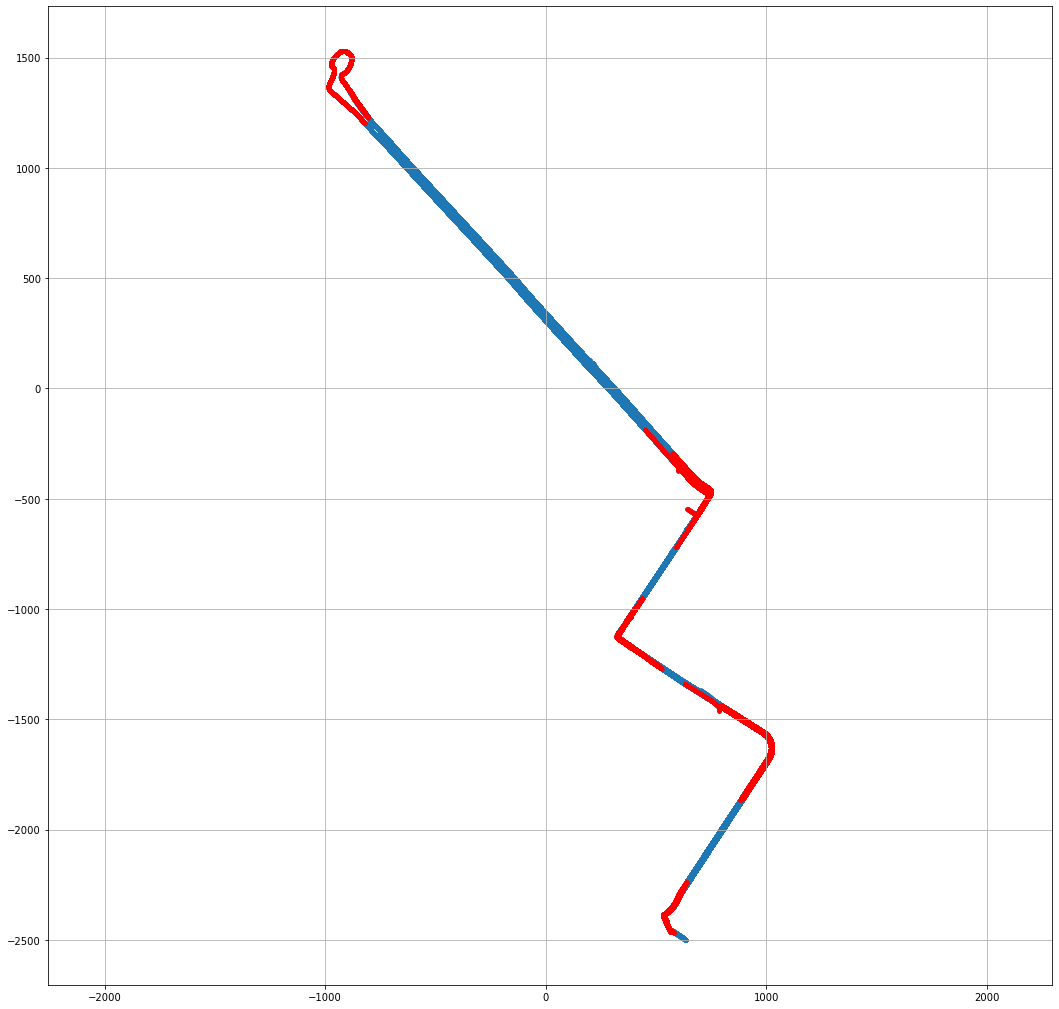

In [80]:
# find the whole trajectories in train.zarr

frames = zarr_dataset.frames

plt.figure(figsize=(18,18))
plt.scatter(frames["ego_translation"][:,0], frames["ego_translation"][:,1], marker='.')
plt.scatter(frames["ego_translation"][tunring_scenes,0], frames["ego_translation"][tunring_scenes,1], marker='.', color='r')
plt.axis("equal")
plt.grid(which='both')
axes = plt.gca()

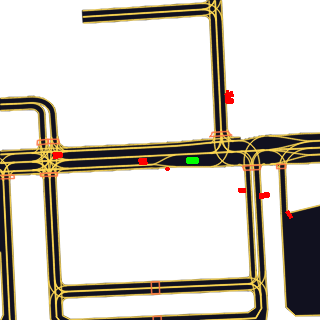

In [224]:
from IPython.display import display, clear_output
import PIL


scene_idx = 7632
indexes = ego_dataset.get_scene_indices(scene_idx)
images = []

for idx in indexes:
    
    data = ego_dataset[idx]
    im = data["image"].transpose(1, 2, 0)
    im = ego_dataset.rasterizer.to_rgb(im)
    target_positions_pixels = transform_points(data["target_positions"], data["raster_from_agent"])
    center_in_pixels = np.asarray(cfg["raster_params"]["ego_center"]) * cfg["raster_params"]["raster_size"]
#     draw_trajectory(im, target_positions_pixels, TARGET_POINTS_COLOR, yaws=data["target_yaws"])
    clear_output(wait=True)
    display(PIL.Image.fromarray(im))

## Now check the lane-junction relation

In [89]:
# first find all junctions and then find the corresponding scene by matching the lane information
def is_junction(elem, map_api):
    return elem.element.HasField("junction")

def get_junctions(map_api):
    return [elem for elem in map_api.elements if is_junction(elem, map_api)]

all_junctions = get_junctions(Map_Api)

id {
  id: "9jWa"
}
element {
  junction {
    road_network_nodes {
      id: "m50v"
    }
    lanes {
      id: "nlTn"
    }
    lanes {
      id: "ORKg"
    }
  }
}
bounding_box {
  south_west {
    lat_e7: 374209307
    lng_e7: -1221453949
  }
  north_east {
    lat_e7: 374209307
    lng_e7: -1221453949
  }
}

In [225]:
scene = 7632

frames = list(range(zarr_dataset.scenes[scene]["frame_index_interval"][0],zarr_dataset.scenes[scene]["frame_index_interval"][1]))

lanes = []

for frame in tqdm(frames[50:100]):
    lanes.append(current_lane(zarr_dataset.frames[frame]['ego_translation'][:2], Lane, Map_Api))
    
lanes = set(lanes)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.13it/s]


In [226]:
# Now define the Junction-Lane dictionary

Junction_Lane = {}

for junction in all_junctions:
    
    Junction_Lane[Map_Api.id_as_str(junction.id)] = []

    for lane in junction.element.junction.lanes:
        Junction_Lane[Map_Api.id_as_str(junction.id)].append(Map_Api.id_as_str(lane))

    Junction_Lane[Map_Api.id_as_str(junction.id)] = set(Junction_Lane[Map_Api.id_as_str(junction.id)])
    
    
junction_index = []

for key in Junction_Lane.keys():
    
    if len(Junction_Lane[key]&lanes) != 0:
        junction_index.append(key)

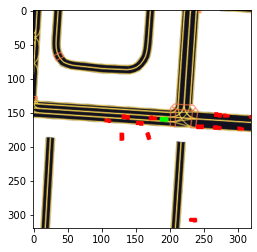

In [216]:
data = ego_dataset[1895697]

im = data["image"].transpose(1, 2, 0)
im = ego_dataset.rasterizer.to_rgb(im)
target_positions_pixels = transform_points(data["target_positions"], data["raster_from_agent"])


plt.imshow(im)
plt.show()

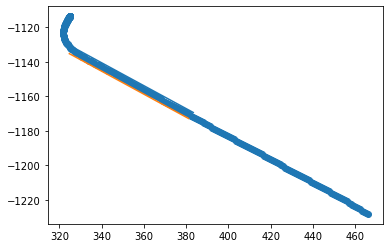

In [230]:
plt.plot(Map_Api.get_lane_coords('fA12')['xyz_left'][:,0],Map_Api.get_lane_coords('fA12')['xyz_left'][:,1])
plt.plot(Map_Api.get_lane_coords('fA12')['xyz_right'][:,0],Map_Api.get_lane_coords('fA12')['xyz_right'][:,1])
plt.scatter(zarr_dataset.frames['ego_translation'][frames][:,0],zarr_dataset.frames['ego_translation'][frames][:,1])

In [227]:
junction_index

['sGK1']

In [228]:
lanes

{'F83z', 'fA12'}

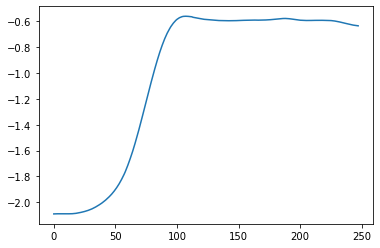

In [223]:
yaw = [rotation33_as_yaw(rotation) for rotation in zarr_dataset.frames['ego_rotation'][frames]]
plt.plot(range(len(yaw)),yaw)

In [130]:
all_junctions

[id {
   id: "fKDq"
 }
 element {
   junction {
     road_network_nodes {
       id: "Igh/"
     }
     road_network_nodes {
       id: "nF79"
     }
     traffic_control_elements {
       id: "sAvc"
     }
     traffic_control_elements {
       id: "Vg0Q"
     }
     lanes {
       id: "JOiU"
     }
   }
 }
 bounding_box {
   south_west {
     lat_e7: 374077634
     lng_e7: -1221449279
   }
   north_east {
     lat_e7: 374077634
     lng_e7: -1221449279
   }
 },
 id {
   id: "2vW8"
 }
 element {
   junction {
     road_network_nodes {
       id: "tk1D"
     }
     traffic_control_elements {
       id: "H3KP"
     }
     lanes {
       id: "A9vw"
     }
     lanes {
       id: "c3Ya"
     }
     lanes {
       id: "YMjM"
     }
     lanes {
       id: "EeYw"
     }
     lanes {
       id: "yYw4"
     }
     lanes {
       id: "Qbza"
     }
   }
 }
 bounding_box {
   south_west {
     lat_e7: 374286029
     lng_e7: -1221514627
   }
   north_east {
     lat_e7: 374286029
     lng_e7: -12